In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches

import geopandas as gpd

import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import numpy as np
from shapely.geometry import Polygon, shape

import os
from itertools import compress


from dbfread import DBF

from pycirclize import Circos
from pycirclize.parser import Matrix
import pandas as pd

from functions.processing.retrieval import getSoundLocations
from functions.processing.recordings import processSingleRecording, processSingleRecordingPoint, computeChangeFrame
from functions.plotting.geo_recordings import plotSingleRecordingAnalysis, plotRecord, plotRecordWithBuffers
from functions.plotting.clc_classes import plotCLCSuperclasses, plotCLCSubclasses, plotCLCClasses, plotChangeChord, plotCLCChanges, plotChangeAnalysis

In [2]:
points = getSoundLocations("Z:\\Audio_data\\Dawn_chorus_raw_data")

In [ ]:
points, dbf_df, geo_df, filtered_dfs, grouped_dfs, weighted_frames, raster_crs = processSingleRecording(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(10, 20))
# points, dbf_df, geo_df, filtered_dfs, grouped_dfs, weighted_frames, raster_crs = processSingleRecording(corine_dir = "C:\\Users\\mfher\\git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(72924,72925))

In [ ]:
# points.to_parquet("points.parquet")

In [5]:
points, dbf_df, geo_df, joined_dfs, raster_crs = processSingleRecordingPoint(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(6350,6360))

Loading raster.
Loaded raster successfully. 
Clipped raster to the point. 
Generating individual pixel.
   value                                           geometry  Value  \
0      2  POLYGON ((4540700 2742700, 4540700 2742600, 45...      2   

        Count                      LABEL3  Red  Green  Blue CODE_18  
0  17085234.0  Discontinuous urban fabric  1.0    0.0   0.0     112  
Assigned class 112 to point 6350
Clipped raster to the point. 
Generating individual pixel.
   value                                           geometry  Value  \
0      2  POLYGON ((4538100 2739200, 4538100 2739100, 45...      2   

        Count                      LABEL3  Red  Green  Blue CODE_18  
0  17085234.0  Discontinuous urban fabric  1.0    0.0   0.0     112  
Assigned class 112 to point 6351
Clipped raster to the point. 
Generating individual pixel.
   value                                           geometry  Value  \
0      2  POLYGON ((4538100 2739200, 4538100 2739100, 45...      2   

        C

f:\Persönliches\Git\BioOTon\functions\processing\recordings.py:272: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '112' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  points.loc[points.index==idx, 'label'] = weighted_class


In [ ]:
# points.to_parquet("points_single.parquet")

f:\Persönliches\Git\BioOTon\functions\plotting\geo_recordings.py:49: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  val_frame.plot(ax=ax, legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])


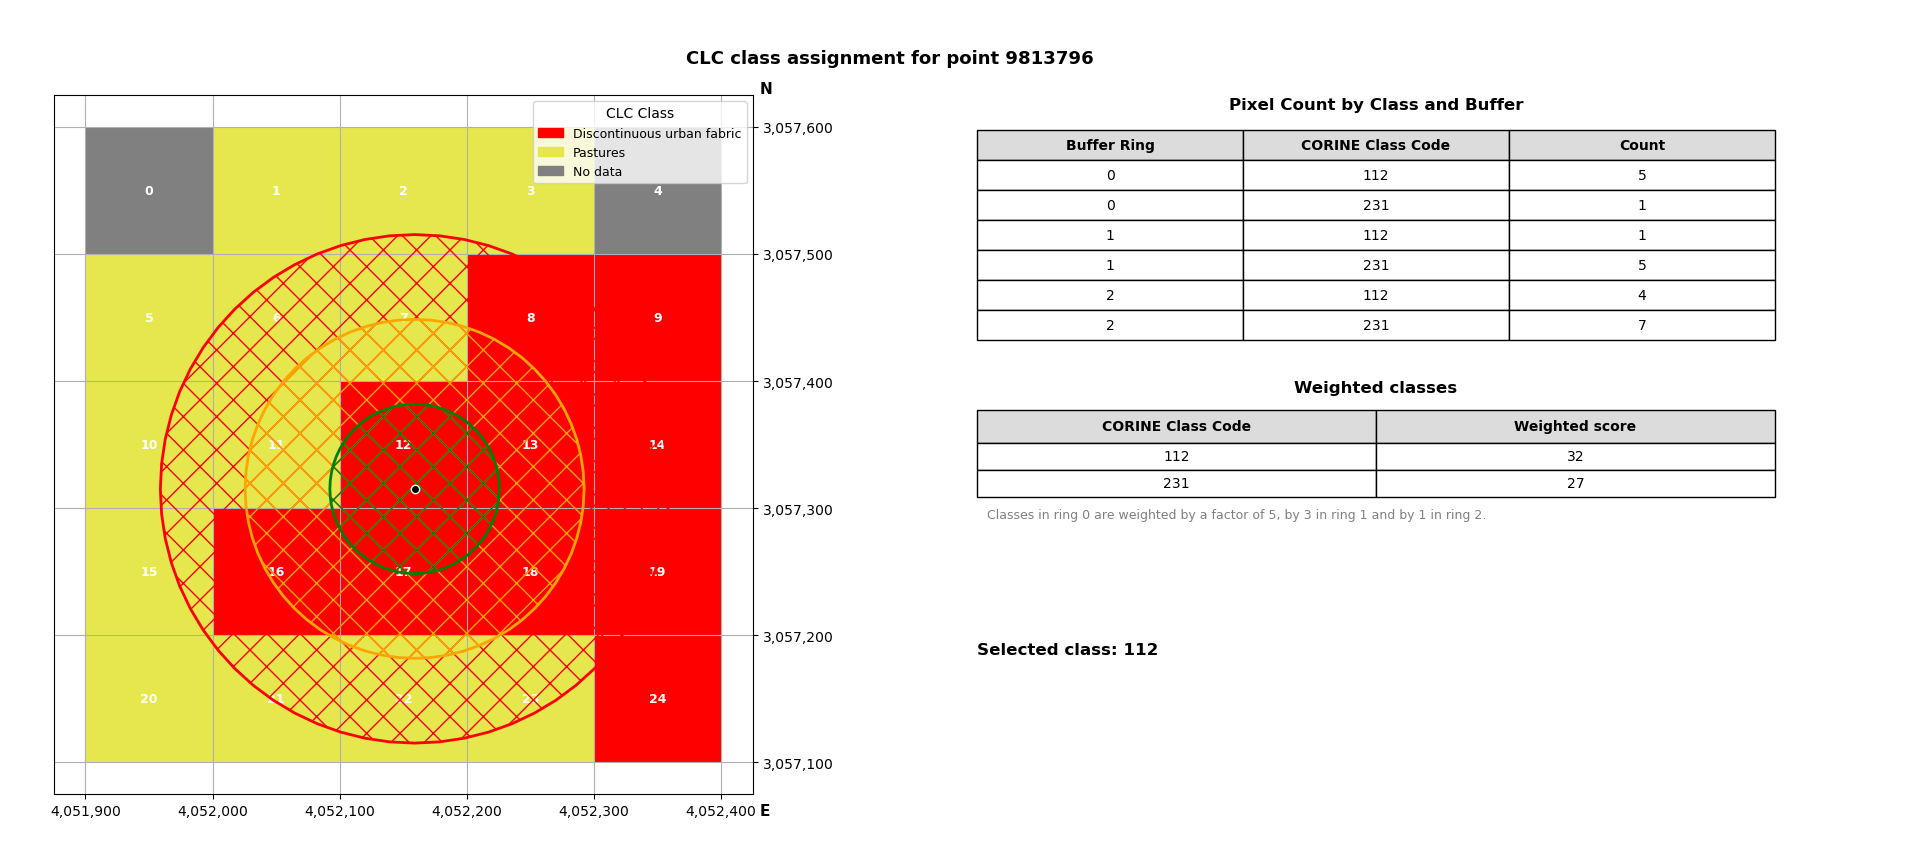

In [4]:
# Only problem with this index scheme is that the indexes are always dependent on how many points were processed previously
fig = plotSingleRecordingAnalysis(point_idx=9, dbf_frame = dbf_df, recording_frame=points, joined_frame=filtered_dfs, environment_frame=geo_df, grouped_frames = grouped_dfs, weighted_frames = weighted_frames, raster_crs=raster_crs)

In [5]:
pframe = pd.read_parquet("points.parquet")
pframe["geometry"] = gpd.GeoSeries.from_wkb(pframe.geometry).buffer(200, cap_style='square')

In [6]:
pframe_single = pd.read_parquet("points_single.parquet")
pframe_single["geometry"] = gpd.GeoSeries.from_wkb(pframe_single.geometry).buffer(200, cap_style='square')

f:\Persönliches\Git\BioOTon\functions\plotting\clc_classes.py:91: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(top=ax.get_ylim()[1] * 5)


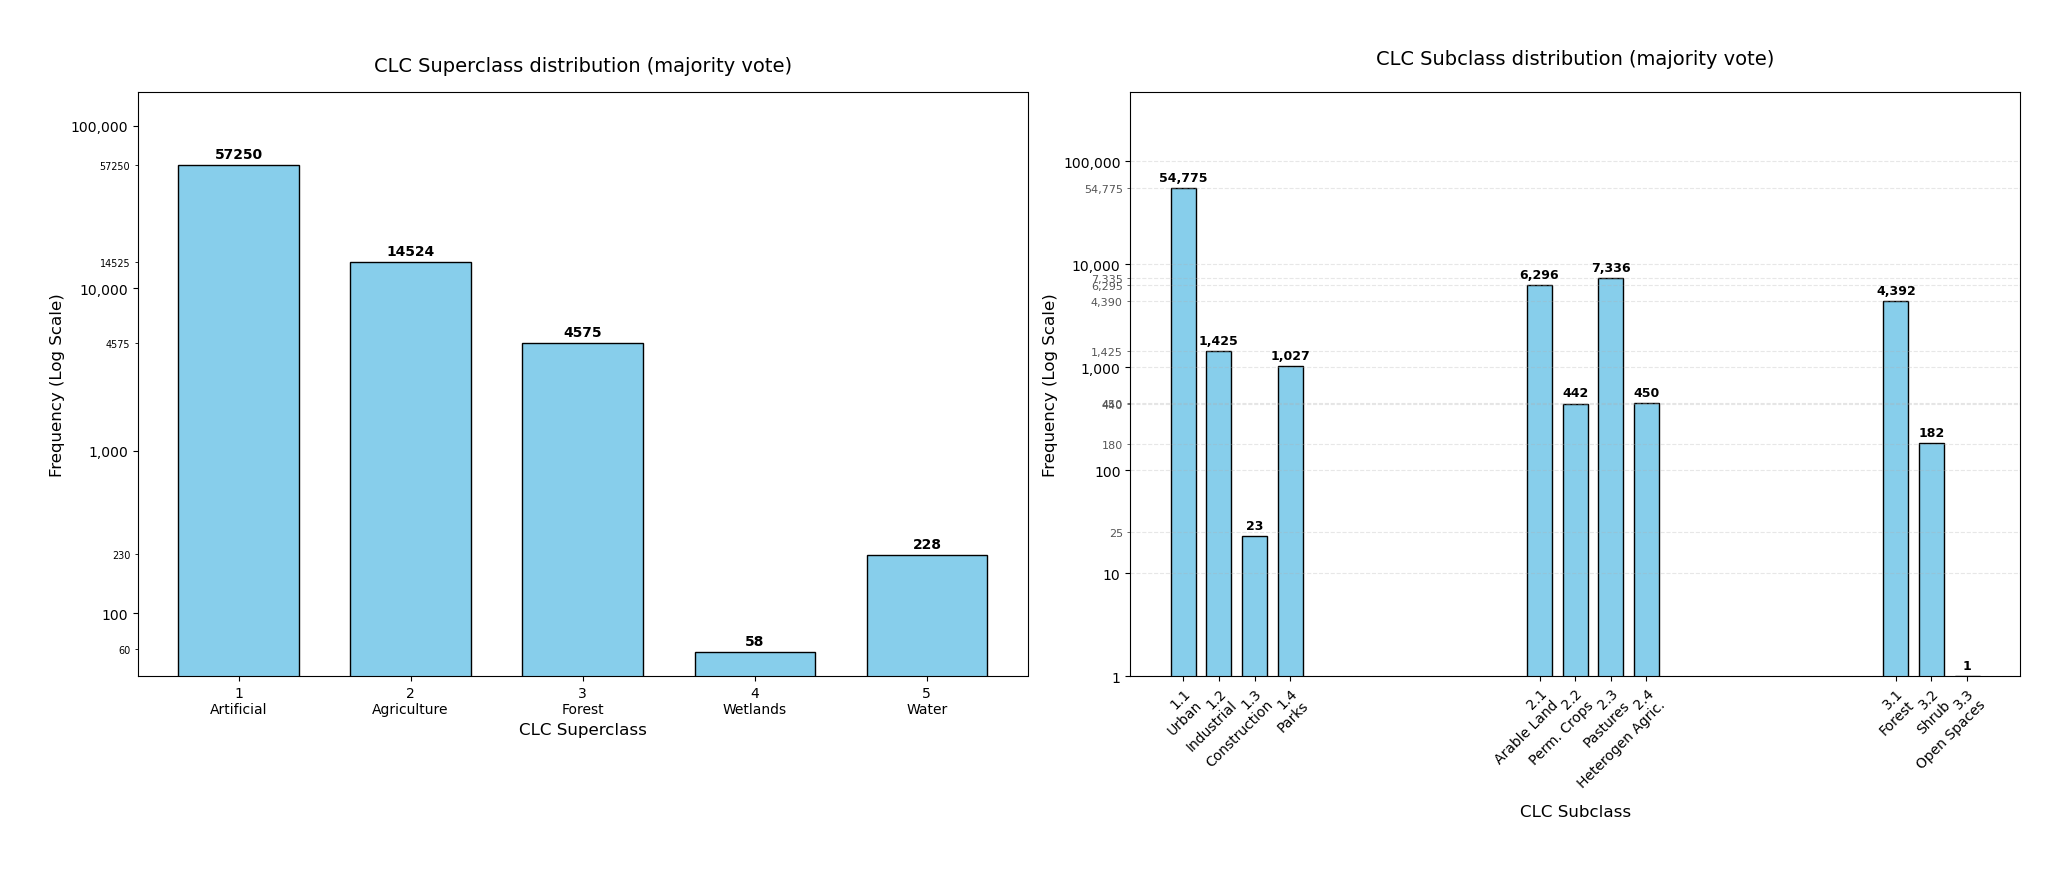

In [7]:
majority_vote = plotCLCClasses(pframe)

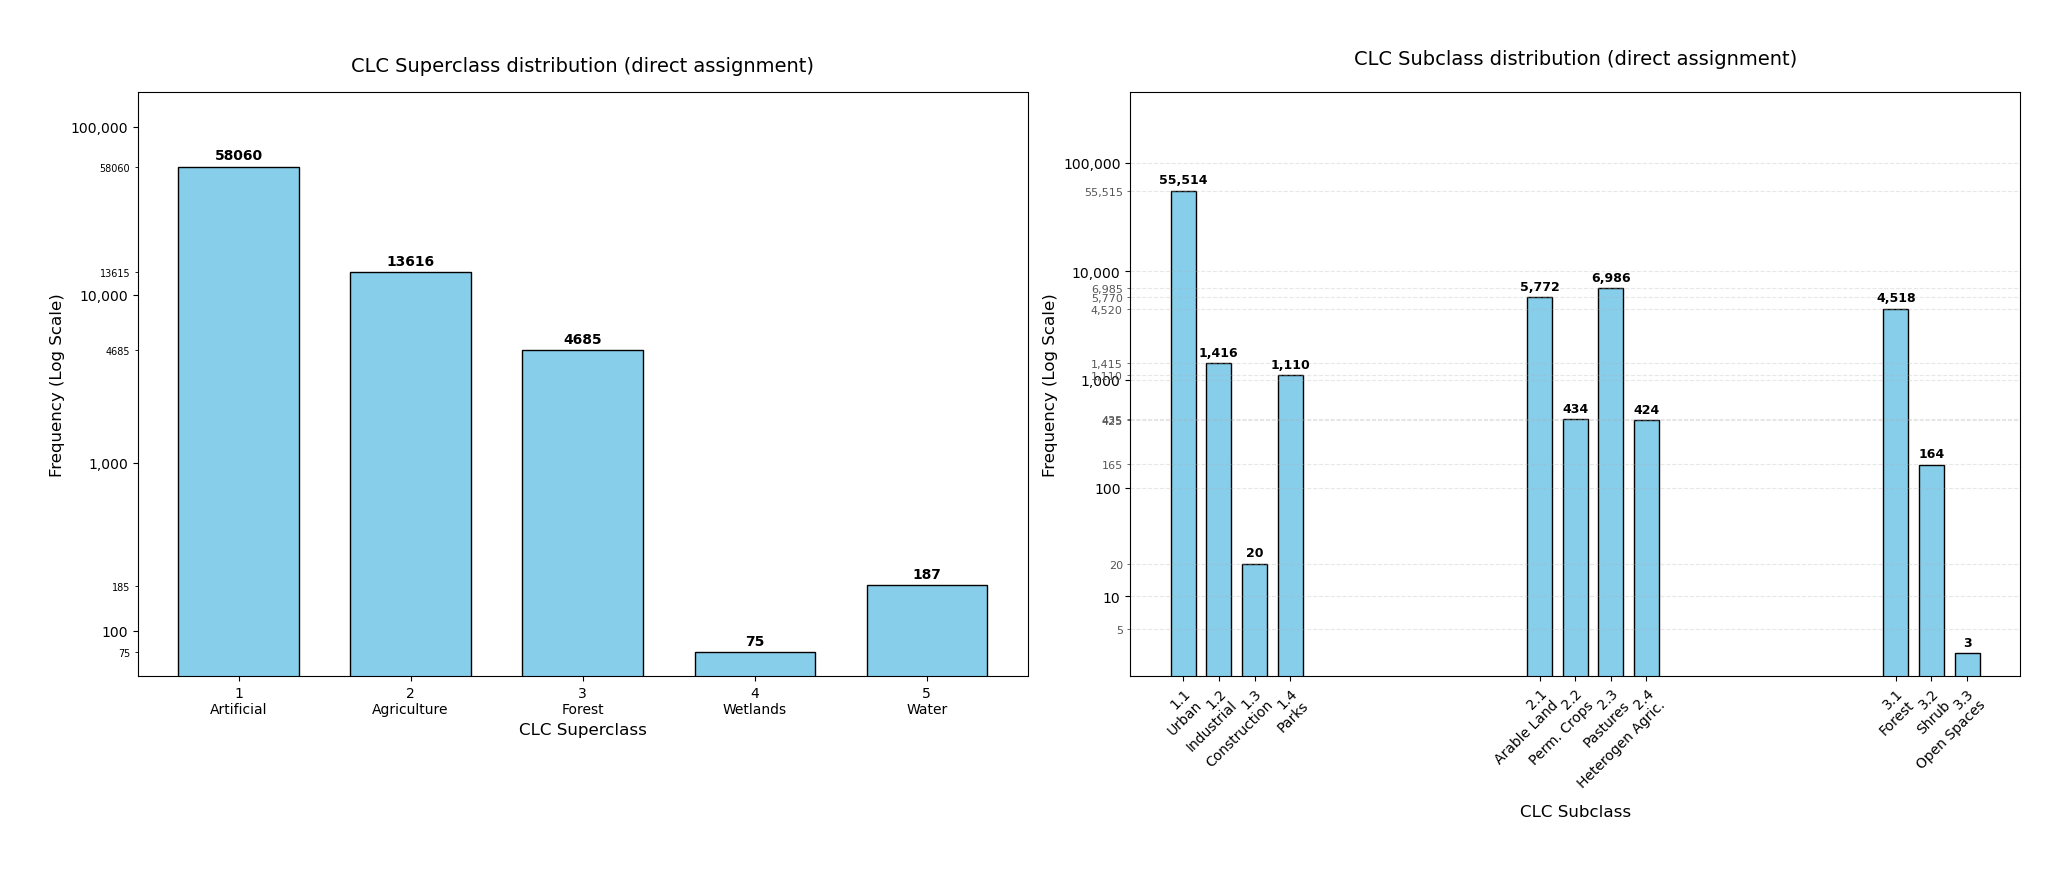

In [8]:
direct_assignment = plotCLCClasses(pframe_single, "direct assignment")

In [ ]:
change_gframe = computeChangeFrame(pframe, pframe_single, raster_crs=raster_crs)

NameError: name 'raster_crs' is not defined

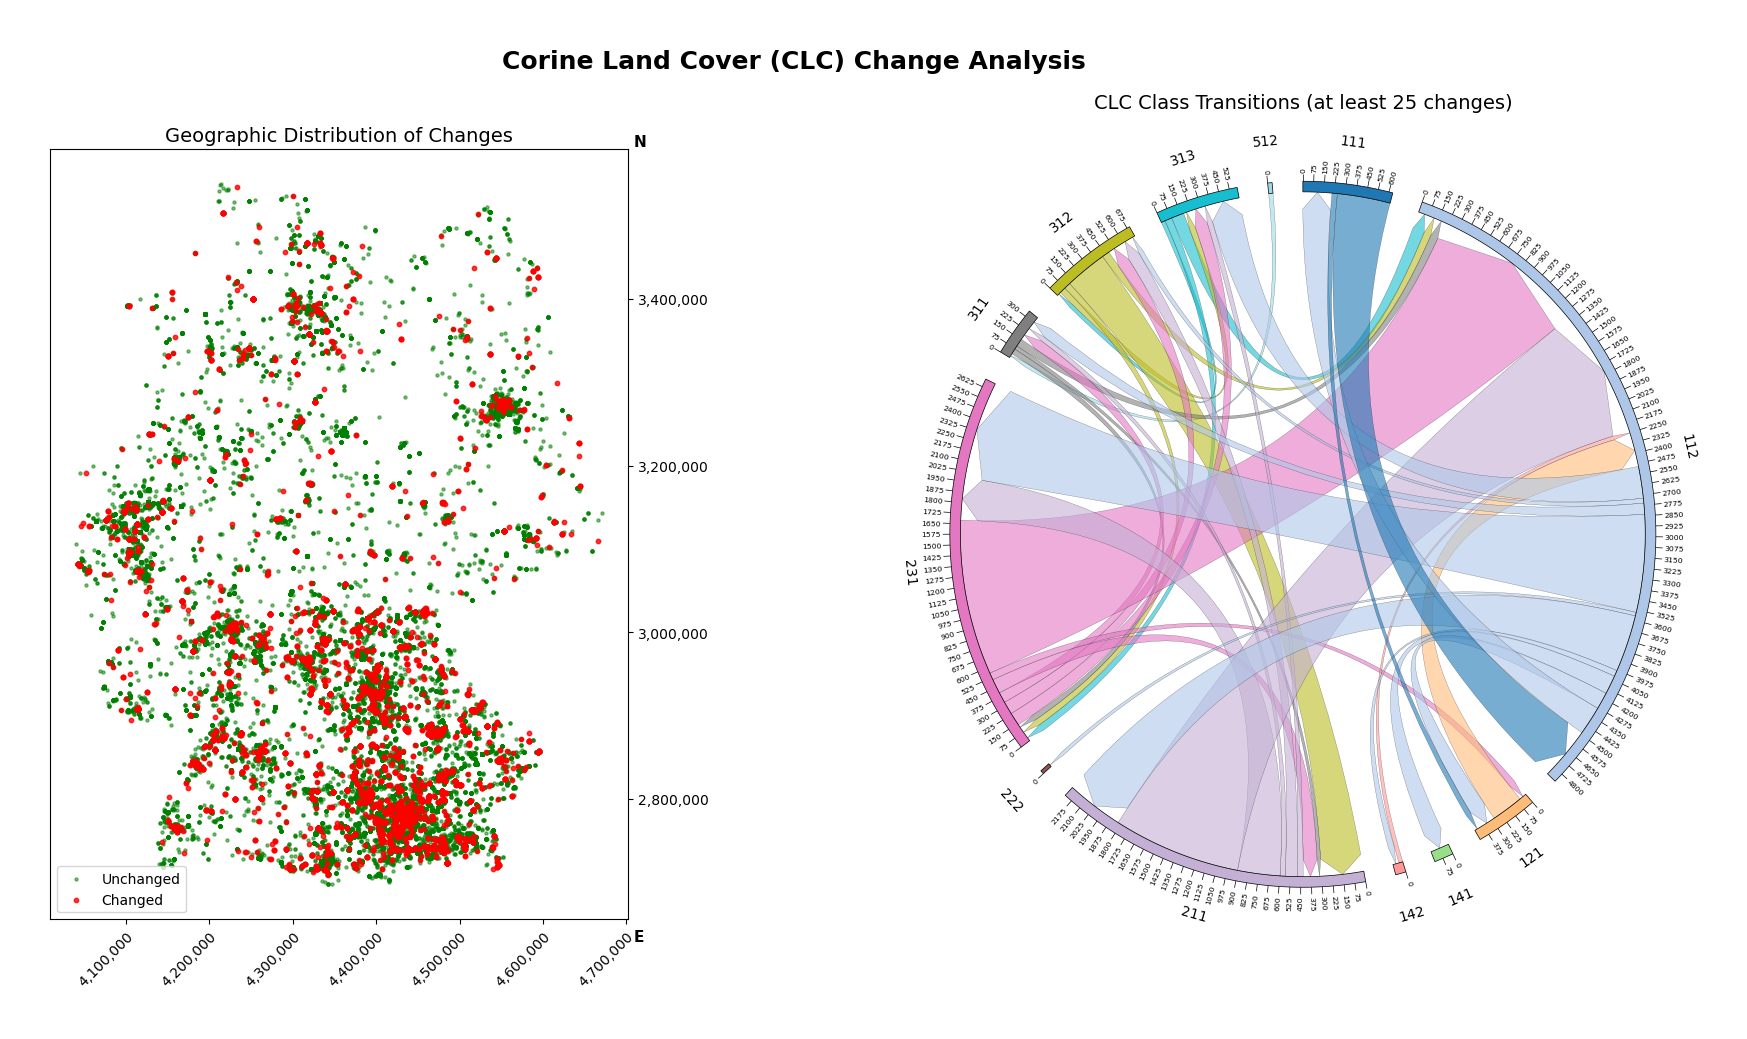

In [7]:
change_analysis = plotChangeAnalysis(change_gframe)